In [9]:
import zipfile

# Download zip file of pizza_steak images
!wget -nc https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

File ‘pizza_steak.zip’ already there; not retrieving.



In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=8,
                                               target_size=(224,224),
                                               class_mode='binary',
                                               seed=42)
test_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=8,
                                               target_size=(224,224),
                                               class_mode='binary',
                                               seed=42)


2021-11-11 09:57:25.093767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-11 09:57:25.093783: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [31]:

def pizza_steak_model():
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    vgg_19 = tf.keras.applications.vgg19.VGG19()
    vgg_19.trainable = False
    x = vgg_19(inputs)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model
model = pizza_steak_model()
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 1000)              143667240 
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 143,668,241
Trainable params: 1,001
Non-trainable params: 143,667,240
_________________________________________________________________


In [32]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [33]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 10**(-1 + epoch/5)) # traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch

history = model.fit(train_data, 
                    epochs=20, 
                    steps_per_epoch=5, # len(train_data), 
                    #validation_data=test_data,
                    #validation_steps=5, # len(test_data),
                    callbacks=[lr_scheduler, ])

Epoch 1/20
5/5 [==============================] - 5s 801ms/step - loss: 0.6884 - accuracy: 0.5278
Epoch 2/20
5/5 [==============================] - 5s 1s/step - loss: 0.7129 - accuracy: 0.3889
Epoch 3/20
5/5 [==============================] - 5s 932ms/step - loss: 0.6890 - accuracy: 0.5250
Epoch 4/20
5/5 [==============================] - 5s 952ms/step - loss: 0.6863 - accuracy: 0.5750
Epoch 5/20
5/5 [==============================] - 5s 1s/step - loss: 0.6493 - accuracy: 0.6750
Epoch 6/20
5/5 [==============================] - 5s 980ms/step - loss: 0.6722 - accuracy: 0.5250
Epoch 7/20
5/5 [==============================] - 5s 1s/step - loss: 0.6566 - accuracy: 0.6000
Epoch 8/20
5/5 [==============================] - 5s 955ms/step - loss: 0.7681 - accuracy: 0.6000
Epoch 9/20
5/5 [==============================] - 5s 971ms/step - loss: 0.6404 - accuracy: 0.6250
Epoch 10/20
5/5 [==============================] - 6s 1s/step - loss: 0.6116 - accuracy: 0.6250
Epoch 11/20
5/5 [==============

In [34]:
import pandas as pd
df_history = pd.DataFrame(history.history)
df_history

,loss,accuracy,lr
0,0.688439,0.527778,0.100000
1,0.712897,0.388889,0.158489
2,0.689008,0.525000,0.251189
3,0.686272,0.575000,0.398107
4,0.649338,0.675000,0.630957
5,0.672196,0.525000,1.000000
6,0.656644,0.600000,1.584893
7,0.768128,0.600000,2.511886
8,0.640438,0.625000,3.981072
9,0.611570,0.625000,6.309574


<AxesSubplot:>

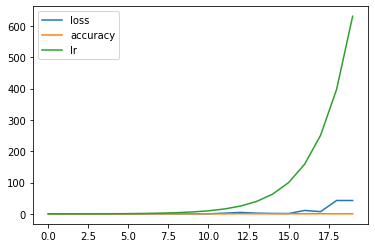

In [35]:
df_history.plot()

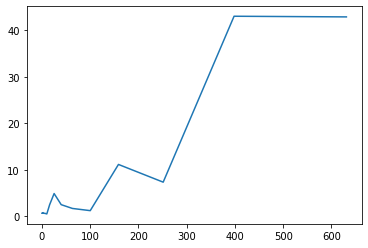

In [36]:
import matplotlib.pyplot as plt
plt.plot(df_history["lr"], df_history["loss"])

In [37]:
model.save("saved_model")

2021-11-11 09:49:27.227131: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/assets


In [38]:
model.evaluate(test_data)

63/63 [==============================] - 66s 1s/step - loss: 93.4293 - accuracy: 0.5040


[93.42933654785156, 0.5040000081062317]

In [5]:
loaded_model = tf.keras.models.load_model("saved_model")

2021-11-11 09:57:36.301742: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-11 09:57:36.325417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 09:57:36.325698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 Ti computeCapability: 7.5
coreClock: 1.485GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2021-11-11 09:57:36.325774: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-11 09:57:36.325821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic li

In [6]:
loaded_model.evaluate(test_data)

2021-11-11 09:57:52.999633: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-11 09:57:53.016876: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2499950000 Hz


 9/63 [===>..........................] - ETA: 54s - loss: 80.6346 - accuracy: 0.5139

KeyboardInterrupt: 